#Preprocesamiento


In [ ]:
#Datos
import numpy as np
import pandas as pd
import math
#Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Outliers
import scipy.stats as st

#Modelado
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Cargo el data set
direc = "https://raw.githubusercontent.com/Akselas/7506R-1C2023-GRUPO26/main/hotels_train.csv"
direc_test = "https://raw.githubusercontent.com/Akselas/7506R-1C2023-GRUPO26/main/hotels_test.csv"
df_test = pd.read_csv(direc_test)
df = pd.read_csv(direc)
df_filtrado  = df.copy()

In [ ]:
# Limpieza del dataset

# Eliminamos columnas para train
df_filtrado = df_filtrado.drop('id', axis=1)
df_filtrado = df_filtrado.drop("reservation_status", axis=1)
df_filtrado = df_filtrado.drop("reservation_status_date", axis=1)
df_filtrado = df_filtrado.drop("company", axis=1)

# Eliminamos columnas para test
test_id = df_test.id.copy()
df_test = df_test.drop('id', axis=1)
df_test = df_test.drop("reservation_status", axis=1)
df_test = df_test.drop("reservation_status_date", axis=1)
df_test = df_test.drop("company", axis=1)

# Se reemplazan los valores nulos por 0 en agents
df_filtrado['agent'] = df_filtrado['agent'].fillna(0)
df_filtrado['agent'] = df_filtrado['agent'].astype(str)

df_test['agent'] = df_test['agent'].fillna(0)
df_test['agent'] = df_test['agent'].astype(str)


#Categorizo los agentes menos populares(no incluyo los agentes 0)
agentes_populares = df_filtrado['agent'].value_counts().index.to_list()[0:14]
def es_agente_popular(agent):
  if agent in agentes_populares:
    return agent
  elif agent == 0:
    return agent
  else:
    return 'otro'

df_filtrado['agent'] = df_filtrado['agent'].apply(es_agente_popular )

# Aca la transformacion aplicada viene del dataset de train
df_test['agent'] = df_test['agent'].apply(es_agente_popular )


# Reemplazamos todas las aparaiciones de paises con pocas apariciones en un pais "otro"
paises = df_filtrado['country'].value_counts()
paises_atipicos = paises[ paises <=100].index.to_list()
def es_pais_atipico(pais):
  if pais in paises_atipicos or pd.isna(pais) :
    return 'otro'
  else:
    return pais

# Aca la transformacion aplicada viene del dataset de train
df_filtrado['country'] = df_filtrado['country'].apply( es_pais_atipico)

df_test['country'] = df_test['country'].apply(es_pais_atipico)


# Esta funcion es solo para test, a todos los paises que no estan en train los categoriza como otro
paises_tipicos = paises[ paises > 100].index.to_list()
def pertenece_a_pais_de_train(pais):
  if pais in paises_atipicos or pais not in paises_tipicos or pd.isna(pais) :
    return 'otro'
  else:
    return pais
df_test['country'] = df_test['country'].apply(pertenece_a_pais_de_train)




#caso de datos nulos en children
#le agrego el valor que mas predomina, que es 0
df_filtrado['children'] = df_filtrado['children'].apply(lambda child: 0 if pd.isna(child) else child)
df_test['children'] = df_test['children'].apply(lambda child: 0 if pd.isna(child) else child)


#caso market segment y distribution channel
a = df_filtrado[df_filtrado['market_segment'] == 'Undefined'].index
df_filtrado.drop(a,  inplace=True, errors='ignore')

b = df_filtrado[df_filtrado['distribution_channel'] == 'Undefined'].index
df_filtrado.drop(b,  inplace=True, errors='ignore')

# No se aplica esto sobre test xq no esta el valor Undefined presente


##categorizo las columnas menos populares con el nombre de "otro"
rooms_mas_populares = df_filtrado['assigned_room_type'].value_counts().index.to_list()[0:8]
df_filtrado['assigned_room_type'] =df_filtrado['assigned_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)
df_filtrado['reserved_room_type'] =df_filtrado['reserved_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)

# Aca la transformacion aplicada viene del dataset de train
df_test['assigned_room_type'] =df_test['assigned_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)
df_test['reserved_room_type'] =df_test['reserved_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)


# Elimino las reservas sin personas
indices_filas_cero = df_filtrado.loc[(df['children'] == 0) & (df['adults'] == 0) & (df['babies'] == 0)].index
df_filtrado = df_filtrado.drop(indices_filas_cero ,errors ='ignore', axis=0)
df_filtrado.reset_index()

,index,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
0,0,City Hotel,49,2016,September,37,5,1,2,1,...,D,0,No Deposit,9.0,0,Transient,115.50,0,1,1
1,1,Resort Hotel,4,2015,October,44,31,0,1,2,...,A,0,No Deposit,0.0,0,Transient,42.00,1,0,0
2,2,City Hotel,25,2016,October,42,13,0,1,2,...,F,0,No Deposit,9.0,0,Transient,229.00,0,2,0
3,3,City Hotel,26,2016,December,51,12,2,5,2,...,A,0,Non Refund,otro,0,Transient,75.00,0,0,1
4,4,City Hotel,104,2017,March,12,19,2,5,2,...,A,0,No Deposit,otro,0,Transient-Party,75.00,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61828,61908,Resort Hotel,24,2017,January,4,27,0,2,2,...,D,0,No Deposit,240.0,0,Transient,48.00,0,1,1
61829,61909,City Hotel,0,2016,September,36,2,0,1,1,...,A,0,No Deposit,0.0,0,Transient,149.00,0,0,0
61830,61910,City Hotel,10,2017,May,19,8,1,2,1,...,A,0,No Deposit,0.0,0,Transient,95.00,0,0,0
61831,61911,Resort Hotel,143,2015,October,41,10,2,5,2,...,A,0,Non Refund,otro,0,Transient,36.05,0,0,1


In [ ]:

# Outliers adr
#Observamos valores negativos que son anomalos
outlier_adr = df_filtrado[df_filtrado["adr"]<=0]


#ELIMINACION de outlier por indice de fila
indice_outlier=df_filtrado[df_filtrado['adr']<=0].index

df_filtrado.drop(indice_outlier, inplace=True)

#Hago z-score modificado
mediana_adr=np.median(df_filtrado.adr)
MAD=np.median(np.absolute(df_filtrado.adr-mediana_adr))
df_filtrado['zm_adr']=(df_filtrado.adr - mediana_adr )*0.6745/MAD
#usando la regla de oro dropeo los que tengan un z-score modificado mayor a 3.5
indice_outlier_z = df_filtrado[df_filtrado['zm_adr']>3.5].index
print(len(indice_outlier_z))
df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outliers para adluts
df_copia_adults = df_filtrado.copy()

#Hago z-score modificado
mediana_adults = np.median(df.adults)
MAD = np.median(np.absolute(df_copia_adults.adults - mediana_adults))
df_copia_adults['zm_adults'] = (df_copia_adults.adults - mediana_adults ) * 0.6745/MAD
indice_outlier_z = df_copia_adults[df_copia_adults['zm_adults'] > 3.5].index
print(f"Cantidad de outliers encontrados con z-score: {len(indice_outlier_z)}")
df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outliers para babys
df_copia_babies = df_filtrado.copy()
#Hago z-score modificado
mediana_babies = np.median(df.babies)
MAD = np.median(np.absolute(df_copia_babies.babies - mediana_babies))
df_copia_babies['zm_babies'] = (df_copia_babies.babies - mediana_babies ) * 0.6745/MAD
indice_outlier_z = df_copia_babies[df_copia_babies['zm_babies'] > 3.5].index
print(f"Cantidad de outliers encontrados con z-score: {len(indice_outlier_z)}")

df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outilers para days_in_waiting_list
#Hago z-score
df_diwl = df_filtrado.copy()
df_diwl['z_diwl'] = st.zscore(df_diwl['days_in_waiting_list'])
indices = df_diwl[df_diwl['z_diwl'] > 3].index
df_fitrado = df_filtrado.drop(indices, axis=0, inplace=True,errors="ignore")


#busco outliers para lead_time
df_lead = df_filtrado.copy()

#Hago z-score modificado
mediana_lead = np.median(df.lead_time)
MAD = np.median(np.absolute(df.lead_time - mediana_lead))
df_lead['zm_lead_time']=(df.lead_time - mediana_lead )*0.6745/MAD
#ELIMINACION: usando la regla de oro ELIMINO los que tengan un z-score modificado mayor a 3.5
indice_outlier_z = df_lead[df_lead['zm_lead_time']>3.5].index
#son 1079 outliers
df_filtrado.drop(indice_outlier_z, inplace=True, errors='ignore',axis=0)

#
df_filtrado.drop('zm_adr', axis=1, inplace=True);

1023
Cantidad de outliers encontrados con z-score: 2968
Cantidad de outliers encontrados con z-score: 392


In [ ]:
ds_trabajo = pd.get_dummies(df_filtrado, columns=["hotel","arrival_date_month","deposit_type","reserved_room_type","assigned_room_type","customer_type","meal","market_segment","distribution_channel","agent","country"], drop_first=True)

df_test = pd.get_dummies(df_test, columns=["hotel","arrival_date_month","deposit_type","reserved_room_type","assigned_room_type","customer_type","meal","market_segment","distribution_channel","agent","country"], drop_first=True)


In [ ]:
x = ds_trabajo.drop(['is_canceled'],axis='columns',inplace=False)
y = ds_trabajo['is_canceled'].copy()
#Creo conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [ ]:
columnas_a_normalizar =[ 'lead_time',                                             
'arrival_date_week_number',            
'arrival_date_day_of_month',           
'stays_in_weekend_nights',             
'stays_in_week_nights',                
'adults',                              
'children',                         
'babies',                              
'previous_cancellations',              
'previous_bookings_not_canceled',      
'booking_changes',                     
'days_in_waiting_list',                
'adr',                               
'required_car_parking_spaces',         
'total_of_special_requests']


df_prediccion_a_normalizar = df_test[columnas_a_normalizar]
df_a_normalizar_train= x_train[columnas_a_normalizar]
df_a_normalizar_test = x_test[columnas_a_normalizar]
len(df_a_normalizar_train)

38306

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(df_a_normalizar_train)

StandardScaler()

In [ ]:
df_normalizado_train = sc.transform(df_a_normalizar_train)
df_normalizado_predict = sc.transform(df_prediccion_a_normalizar)
i=0
for col in columnas_a_normalizar:
  #obtengo una columna
  df_test[col]= df_normalizado_predict[:,i]
  x_train[col]= df_normalizado_train[:,i]
  i=i+1

#x_train
#df_test

In [ ]:
df_normalizado_test = sc.transform(df_a_normalizar_test)
i=0
for col in columnas_a_normalizar:
  #obtengo una columna
  x_test[col]= df_normalizado_test[:,i]
  i=i+1

#x_test

#Red Neuronal


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import pandas as pd
import numpy as np
import random

from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

# import visualkeras

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1) 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
x_train.shape

(38306, 107)

# Busqueda de hiperparametros

In [ ]:
# calcula la cantidad de clases
cant_clases=len(np.unique(x_train))
d_in=len(x_train.columns)

#Funcion para modelar y compilar la red neuronal:
def modelar(neuronas, learning_rate, beta_1, beta_2, epsilon):
    modelo_hotel = keras.Sequential([
      keras.layers.Dense(d_in, input_shape=(d_in,)),
      keras.layers.Dense(neuronas, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])
    
    modelo_hotel.compile(
      optimizer=keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon), 
      #optimizer=keras.optimizers.SGD(learning_rate=0.0009), 
      loss='binary_crossentropy', 
      metrics=['AUC'], 
      )
    return modelo_hotel
# Crear el clasificador de Keras
clasificador = KerasClassifier(build_fn=modelar, verbose=0)

# Definir los hiperparámetros a ajustar y sus valores posibles
hiperparametros = {'neuronas': list(range(50,107)),
                   'learning_rate': [0.1, 0.01, 0.001],
                   'beta_1': [0.9, 0.95, 0.99],
                   'beta_2': [0.99, 0.999, 0.9999],
                   'epsilon': [1e-7, 1e-8, 1e-9]
                  }

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Hacer el randomizedsearch para buscar hiperparametros
random_search = RandomizedSearchCV(estimator=clasificador,                       
                              param_distributions = hiperparametros,
                              scoring=scorer_fn,
                              cv=kfoldcv, error_score='raise', random_state = 4)
random_resultado = random_search.fit(x_train, y_train)

240/240 [==============================] - 1s 2ms/step


In [ ]:
# Imprimir los resultados
print("Mejores hiperparámetros: ", random_resultado.best_params_)
print("Mejor precisión: ", random_resultado.best_score_)


Mejores hiperparámetros:  {'neuronas': 80, 'learning_rate': 0.01, 'epsilon': 1e-07, 'beta_2': 0.999, 'beta_1': 0.99}
Mejor precisión:  0.8052374863665952


In [ ]:
random_resultado.cv_results_['mean_test_score']

array([0.64772008, 0.53250893, 0.78738375, 0.66562162, 0.80324649,
       0.72531597, 0.        , 0.66562162, 0.80523749, 0.6922336 ])

In [ ]:
best_fit = random_resultado.best_estimator_

In [ ]:
predict_y_test = best_fit.predict(x_test)

514/514 [==============================] - 1s 2ms/step


Estas son las metricas del best fit para esos hiperparametros

#Entrenamiento

In [ ]:
# calcula la cantidad de clases
cant_clases=len(np.unique(x_train))
d_in=len(x_train.columns)

modelo_hotel = keras.Sequential([
    keras.layers.Dense(107,input_shape=(d_in,)),
    keras.layers.Dense(80, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')])
    
    #keras.layers.Dense(1, activation='relu')])

modelo_hotel.summary()

Model: "sequential_216"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_648 (Dense)           (None, 107)               11556     
                                                                 
 dense_649 (Dense)           (None, 80)                8640      
                                                                 
 dense_650 (Dense)           (None, 1)                 81        
                                                                 
Total params: 20,277
Trainable params: 20,277
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo_hotel.compile(
  optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-07),
  loss='binary_crossentropy', 
  # metricas para ir calculando en cada iteracion o batch 
  #metrics=['MeanSquaredError'], 
  metrics=['AUC'],
)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=5)
cant_epochs_hotel=100
modelo_hotel_hitoria = modelo_hotel.fit(x_train,y_train,epochs=cant_epochs_hotel,batch_size=20,verbose=False,callbacks=[callback])

In [ ]:
modelo_hotel_hitoria.history

{'loss': [0.7025270462036133,
  0.4454444646835327,
  0.4418705999851227,
  0.4346088171005249,
  0.4302651882171631,
  0.4302544891834259,
  0.4236621856689453,
  0.4217821955680847,
  0.41845449805259705,
  0.4169948101043701,
  0.4121379554271698,
  0.40987107157707214,
  0.40809667110443115,
  0.40801265835762024,
  0.40774473547935486,
  0.4052852690219879,
  0.404207706451416,
  0.404619961977005,
  0.4021541178226471,
  0.4005813002586365,
  0.39989957213401794,
  0.39905473589897156,
  0.3985564410686493,
  0.39964285492897034,
  0.3970237076282501,
  0.395169198513031,
  0.39666876196861267,
  0.3941638469696045,
  0.39460670948028564,
  0.3954073190689087,
  0.3976093828678131,
  0.3932968080043793,
  0.3906303346157074,
  0.39628708362579346,
  0.3928721249103546,
  0.39422619342803955,
  0.3922843635082245,
  0.38877370953559875,
  0.38421133160591125,
  0.37761759757995605,
  0.3710019588470459,
  0.37095698714256287,
  0.3649863600730896,
  0.36451542377471924,
  0.377049

# Prediccion

514/514 [==============================] - 2s 4ms/step


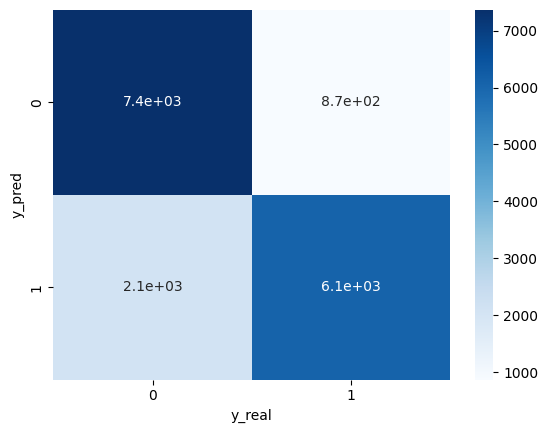

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      8233
           1       0.87      0.74      0.80      8185

    accuracy                           0.82     16418
   macro avg       0.83      0.82      0.82     16418
weighted avg       0.83      0.82      0.82     16418



In [ ]:
y_predic_ej1 = modelo_hotel.predict(x_test)
y_predic_ej1
y_predic_cat_ej1 = np.where(y_predic_ej1>0.6,1,0)

ds_validacion=pd.DataFrame(y_predic_cat_ej1,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()
print(classification_report(y_test,y_predic_cat_ej1))

In [ ]:
modelo_hotel.save("model.h5")

In [ ]:
nuevo_modelo = keras.models.load_model("model.h5")
nuevo_modelo.predict(x_test)

514/514 [==============================] - 1s 2ms/step


array([[3.5533860e-01],
       [2.2716051e-01],
       [1.2512550e-07],
       ...,
       [8.6756414e-03],
       [9.9793959e-01],
       [1.5920493e-01]], dtype=float32)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Columns: 107 entries, lead_time to country_otro
dtypes: float64(15), int64(2), uint8(90)
memory usage: 5.7 MB


In [ ]:
y_predict = modelo_hotel.predict(df_test)
y_predict_cat_ej1 = np.where(y_predict>0.6,1,0)

submit =  pd.DataFrame(zip(test_id,y_predict_cat_ej1),columns=['id','is_canceled'])
#submit[is_canceled]

#submit.to_csv('./random_forest_submit.csv',index=False)  

830/830 [==============================] - 2s 2ms/step


In [ ]:
len(y_predict)

26535

In [ ]:
submit['is_canceled'] = submit['is_canceled'].astype(int)
submit

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,0
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,0
26531,11e19741-bd28-4459-8ea3-184f1664000f,0
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,1
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,1


In [ ]:
submit.to_csv('./red_neuronal_submit.csv',index=False)  

#"Visualizacion"

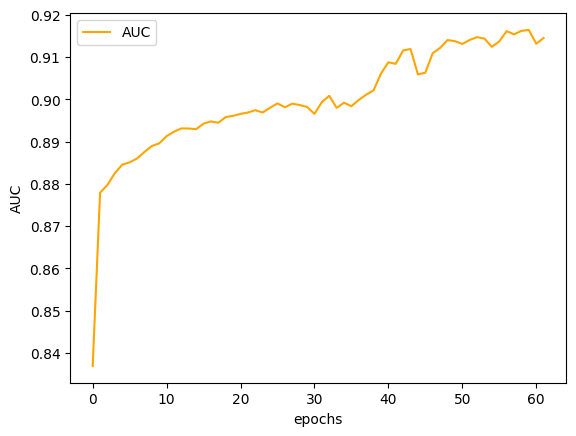

In [ ]:
epochs = range(len(modelo_hotel_hitoria.history['auc']))

plt.plot(epochs, modelo_hotel_hitoria.history['auc'], color='orange', label='AUC')
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

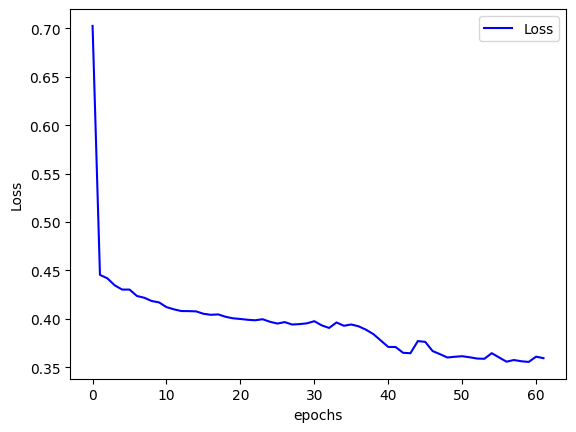

In [ ]:
plt.plot(epochs, modelo_hotel_hitoria.history['loss'], color='blue', label='Loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()